# ***Import Needed Libraries*** 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import re,json,nltk
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.metrics import  confusion_matrix
import seaborn
from sklearn.feature_extraction.text import CountVectorizer
import plotly as py
import cufflinks as cf
from plotly.offline import iplot
py.offline.init_notebook_mode(connected=True)
cf.go_offline()

2021-08-06 16:00:38.417814: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


# ***Load Dataset***

In [2]:
data = pd.read_csv("Conversation.csv")
data

,Conversation,Sentiment
0,আমি বুথ থেকে কল দেয়ার জন্য দুঃখিত,negative
1,আমি তোমার সম্পর্কে দুঃখিত,negative
2,আমার ভয় হচ্ছিল আমি খুব ভয় পেয়েছিলাম,negative
3,অবশ্যই ধন্যবাদ,positive
4,কী সুন্দর!! আমি খুব খুশি,positive
...,...,...
1136,"ওই, কে রে শালা তুই?",negative
1137,সবকিছুই পরিকল্পনা মাফিক হবে,positive
1138,তুই কোন নরক থেকে এসেছিস রে?,negative
1139,এখানেই মরবি তুই।,negative


In [3]:
data

,Conversation,Sentiment
0,আমি বুথ থেকে কল দেয়ার জন্য দুঃখিত,negative
1,আমি তোমার সম্পর্কে দুঃখিত,negative
2,আমার ভয় হচ্ছিল আমি খুব ভয় পেয়েছিলাম,negative
3,অবশ্যই ধন্যবাদ,positive
4,কী সুন্দর!! আমি খুব খুশি,positive
...,...,...
1136,"ওই, কে রে শালা তুই?",negative
1137,সবকিছুই পরিকল্পনা মাফিক হবে,positive
1138,তুই কোন নরক থেকে এসেছিস রে?,negative
1139,এখানেই মরবি তুই।,negative


In [4]:
print("Total sentiment:",len(data),
      "\nTotal pos sentiment:",len(data[data.Sentiment =='positive']),
      "\nTotal neg sentiment:",len(data[data.Sentiment=='negative']))

Total sentiment: 1141 
Total pos sentiment: 570 
Total neg sentiment: 571


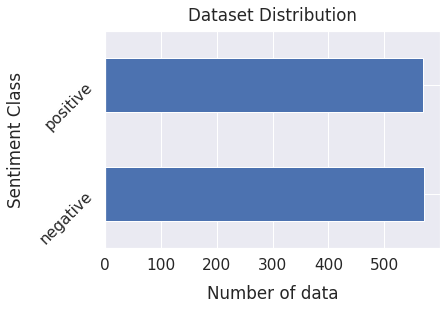

In [5]:
sns.set(font_scale=1.4)
data['Sentiment'].value_counts().plot(kind='barh', figsize=(6, 4))
plt.xlabel("Number of data", labelpad=12)
plt.ylabel("Sentiment Class", labelpad=12)
plt.yticks(rotation = 45)
plt.title("Dataset Distribution", y=1.02);

# ***Data Preparation And Cleaning***

In [6]:
sample_data = [10,52,1136,1138]
for i in sample_data:
      print(data.Conversation[i],'\n','Sentiment:-- ',data.Sentiment[i],'\n')

দুর্দান্ত তুমি কি তাতে খুশি?  হ্যাঁ, আমি শিহরিত খুঁজে পেয়েছি! 
 Sentiment:--  positive 

বড় হয়ে ওঠো চমৎকার মানুষ হিসেবে, ঠিক আছে? 
 Sentiment:--  positive 

ওই, কে রে শালা তুই? 
 Sentiment:--  negative 

তুই কোন নরক থেকে এসেছিস রে? 
 Sentiment:--  negative 



**Define functions for data cleaning**

In [7]:
def process_conversations(Conversation): 
    stp = open('bangla_stopwords.txt','r',encoding="utf8").read().split()
    result = Conversation.split()
    Conversation = [word.strip() for word in result if word not in stp ]
    Conversation =" ".join(Conversation)
    Conversation = re.sub('[^\u0980-\u09FF]',' ',str(Conversation))
    return Conversation


In [8]:
data['cleaned'] = data['Conversation'].apply(process_conversations)  
sample_data = [10,150,1140]
for i in sample_data:
     print('Original:\n',data.Conversation[i],'\nCleaned:\n',
           data.cleaned[i],'\n','Sentiment:-- ',data.Sentiment[i],'\n')

Original:
 দুর্দান্ত তুমি কি তাতে খুশি?  হ্যাঁ, আমি শিহরিত খুঁজে পেয়েছি! 
Cleaned:
 দুর্দান্ত খুশি  হ্যাঁ  শিহরিত খুঁজে পেয়েছি  
 Sentiment:--  positive 

Original:
 আমরা স্বামী-স্ত্রী এখনো একে অপরকে ভালবাসি 
Cleaned:
 স্বামী স্ত্রী এখনো অপরকে ভালবাসি 
 Sentiment:--  positive 

Original:
 আপনি যা করেছেন তার জন্যে আপনাকে মেরে ফেলা উচিত 
Cleaned:
 জন্যে মেরে ফেলা 
 Sentiment:--  negative 



In [9]:
data['length'] = data['cleaned'].apply(lambda x:len(x.split()))

dataset = data.loc[data.length>0]
dataset = dataset.reset_index(drop = True)
print("After Cleaning:","\nRemoved {} Small conversations".format(len(data)-len(dataset)),
      "\nTotal conversations:",len(dataset))

dataset['no_char'] = data['cleaned'].apply(lambda cleaned: len(cleaned))

After Cleaning: 
Removed 0 Small conversations 
Total conversations: 1141


In [10]:
dataset

,Conversation,Sentiment,cleaned,length,no_char
0,আমি বুথ থেকে কল দেয়ার জন্য দুঃখিত,negative,বুথ কল দেয়ার দুঃখিত,4,19
1,আমি তোমার সম্পর্কে দুঃখিত,negative,সম্পর্কে দুঃখিত,2,15
2,আমার ভয় হচ্ছিল আমি খুব ভয় পেয়েছিলাম,negative,ভয় হচ্ছিল ভয় পেয়েছিলাম,4,24
3,অবশ্যই ধন্যবাদ,positive,অবশ্যই ধন্যবাদ,2,14
4,কী সুন্দর!! আমি খুব খুশি,positive,সুন্দর খুশি,2,13
...,...,...,...,...,...
1136,"ওই, কে রে শালা তুই?",negative,ওই রে শালা তুই,4,16
1137,সবকিছুই পরিকল্পনা মাফিক হবে,positive,সবকিছুই পরিকল্পনা মাফিক,3,23
1138,তুই কোন নরক থেকে এসেছিস রে?,negative,তুই নরক এসেছিস রে,4,18
1139,এখানেই মরবি তুই।,negative,মরবি তুই,2,9


# ***Data Visualization***

In [11]:
dataset['Sentiment'].value_counts().iplot()

In [12]:
dataset['length'].iplot(colors='orange',xTitle ='No. Conversation',yTitle ='No. Words',title='Word Frequency ')

In [13]:
dataset['no_char'].iplot(colors='orange',kind='bar',xTitle ='No. Conversation',yTitle ='No. Character',title='Character Frequency ')

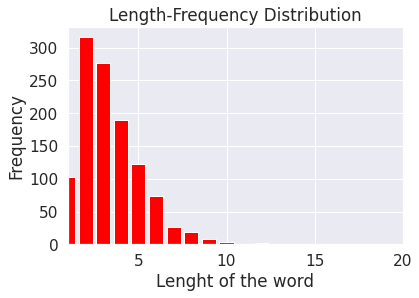

Maximum Length of a review: 16
Minimum Length of a review: 1
Average Length of a reviews: 3.0


In [14]:
frequency = dict()
for i in dataset.length:
    frequency[i] = frequency.get(i, 0)+1

plt.bar(frequency.keys(), frequency.values(), color ="red")
plt.xlim(1, 20)

plt.xlabel('Lenght of the word')
plt.ylabel('Frequency')
plt.title('Length-Frequency Distribution')
plt.show()  
print(f"Maximum Length of a review: {max(dataset.length)}")
print(f"Minimum Length of a review: {min(dataset.length)}")
print(f"Average Length of a reviews: {round(np.mean(dataset.length),0)}")

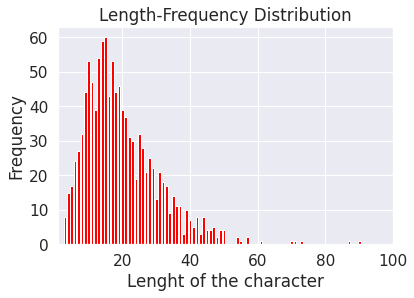

Maximum Length of a review: 90
Minimum Length of a review: 3
Average Length of a reviews: 20.0


In [15]:
frequency = dict()
for i in dataset.no_char:
    frequency[i] = frequency.get(i, 0)+1

plt.bar(frequency.keys(), frequency.values(), color ="red")
plt.xlim(1, 100)

plt.xlabel('Lenght of the character')
plt.ylabel('Frequency')
plt.title('Length-Frequency Distribution')
plt.show()  
print(f"Maximum Length of a review: {max(dataset.no_char)}")
print(f"Minimum Length of a review: {min(dataset.no_char)}")
print(f"Average Length of a reviews: {round(np.mean(dataset.no_char),0)}")

***Unigram Distribution***

In [16]:
x = ['বুথ কল দেয়ার দুঃখিত']

In [17]:
def get_top_n_words(x, n):
    vec = CountVectorizer().fit(x)
    bow = vec.transform(x)
    sum_words = bow.sum(axis = 0)
    words_freq = [(word, sum_words[0,idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse = True)
    return words_freq[:n]

get_top_n_words(x,3)
    

[('কল', 1)]

In [18]:
unigram_words = get_top_n_words(data['cleaned'],20)
unigram_words

[('কর', 107),
 ('বন', 50),
 ('বল', 45),
 ('আছ', 38),
 ('দর', 36),
 ('রক', 32),
 ('সম', 30),
 ('পর', 30),
 ('জন', 29),
 ('করব', 26),
 ('করছ', 26),
 ('আম', 25),
 ('কষ', 25),
 ('যব', 24),
 ('হয়', 24),
 ('সত', 22),
 ('রব', 21),
 ('গল', 18),
 ('পড়', 18),
 ('সব', 18)]

In [19]:
df = pd.DataFrame(unigram_words, columns = ['Unigram', 'Frequency'])
df = df.set_index('Unigram')
df.iplot(kind='bar', xTitle = 'Unigram', yTitle = 'Count',title = 'Top 20 Unigram Words')

***Bigram Distribution***

In [20]:
def get_top_n_words(x, n):
    vec = CountVectorizer(ngram_range=(2, 2)).fit(x)
    bow = vec.transform(x)
    sum_words = bow.sum(axis = 0)
    words_freq = [(word, sum_words[0,idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse = True)
    return words_freq[:n]
    

In [21]:
bigram_words = get_top_n_words(data['cleaned'],20)
bigram_words

[('ধন যব', 16),
 ('সম পর', 13),
 ('অবশ যই', 10),
 ('বন কর', 8),
 ('পছন কর', 6),
 ('রক কর', 6),
 ('ঈশ বর', 5),
 ('জন মদ', 4),
 ('কষ আছ', 4),
 ('দয কর', 4),
 ('সব ইক', 4),
 ('আম রক', 4),
 ('কল পন', 3),
 ('হত কর', 3),
 ('অর জন', 3),
 ('দর শন', 3),
 ('যন রণ', 3),
 ('মঙ গল', 3),
 ('গল কর', 3),
 ('হস হয়', 3)]

In [22]:
df1 = pd.DataFrame(bigram_words, columns = ['Bigram', 'Frequency'])
df1 = df1.set_index('Bigram')
df1.iplot(kind='bar', xTitle = 'Bigram', yTitle = 'Count',title = 'Top 20 Bigram Words')

 ***Trigram Distribution***

In [23]:
def get_top_n_words(x, n):
    vec = CountVectorizer(ngram_range=(3, 3)).fit(x)
    bow = vec.transform(x)
    sum_words = bow.sum(axis = 0)
    words_freq = [(word, sum_words[0,idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse = True)
    return words_freq[:n]
    

In [24]:
trigram_words = get_top_n_words(data['cleaned'],20)
trigram_words

[('মঙ গল কর', 3),
 ('পর কল পন', 2),
 ('সম পর বল', 2),
 ('ধরন পছন কর', 2),
 ('টক বন কর', 2),
 ('যন রণ আছ', 2),
 ('পথ রন তন', 2),
 ('রন তন সত', 2),
 ('ভগব মঙ গল', 2),
 ('আম রক এন', 2),
 ('ভয় হচ ভয', 1),
 ('অবশ যই ধন', 1),
 ('যই ধন যব', 1),
 ('শর য়ন রণ', 1),
 ('অবস বর ণন', 1),
 ('বর ণন কঠ', 1),
 ('ভব যতট বর', 1),
 ('কর ভয নক', 1),
 ('রত যয অভ', 1),
 ('যয অভ কর', 1)]

In [25]:
df2 = pd.DataFrame(trigram_words, columns = ['Trigram', 'Frequency'])
df2 = df2.set_index('Trigram')
df2.iplot( kind = 'bar',xTitle = 'Trigram', yTitle = 'Count',title = 'Top 20 Trigram Words')

# ***Dataset Summary***

In [26]:
def data_summary(dataset):
    documents = []
    words = []
    most_frequent_word =[]
    u_words = []
   
    total_u_words = [word.strip().lower() for t in list(dataset.cleaned) for word in t.strip().split()]
    class_label= [k for k,v in dataset.Sentiment.value_counts().to_dict().items()]

    for label in class_label: 
        word_list = [word.strip().lower() for t in list(dataset[dataset.Sentiment==label].cleaned) for word in t.strip().split()]
        
        counts = dict()
        
        for word in word_list:
                counts[word] = counts.get(word, 0)+1
      
        ordered = sorted(counts.items(), key= lambda item: item[1],reverse = True)
    
        documents.append(len(list(dataset[dataset.Sentiment==label].cleaned)))
        
        words.append(len(word_list))
         
        u_words.append(len(np.unique(word_list)))
       
        print("\nClass Name : ",label)
        print("Number of Documents:{}".format(len(list(dataset[dataset.Sentiment==label].cleaned))))  
        print("Number of Words:{}".format(len(word_list))) 
        print("Number of Unique Words:{}".format(len(np.unique(word_list)))) 
        print("Most Frequent Words:\n")
        for k,v in ordered[:15]:
              print("{}\t{}".format(k,v))
    print("Total Number of Unique Words:{}".format(len(np.unique(total_u_words))))           
   
    return documents,words,u_words,class_label

documents,words,u_words,class_names = data_summary(dataset)


Class Name :  negative
Number of Documents:571
Number of Words:1944
Number of Unique Words:1045
Most Frequent Words:

মারা	37
কেন	29
না	28
তুই	25
শালা	20
গেছে	19
কর	17
মেরে	17
দুঃখিত	16
কষ্ট	16
তোর	14
বন্ধ	13
চুপ	13
আছে	11
সমস্যা	9

Class Name :  positive
Number of Documents:570
Number of Words:1931
Number of Unique Words:1094
Most Frequent Words:

সুন্দর	29
খুশি	27
জীবন	17
ধন্যবাদ	16
ভালো	16
পছন্দ	15
প্রেমে	12
না	12
চাই	11
আছে	10
বড়	10
বিয়ে	10
অবশ্যই	9
ফোন	9
নেই	9
Total Number of Unique Words:1858


***New Dataframe for Data Summary***

In [27]:
data_matrix = pd.DataFrame({'Total Documents':documents,
                            'Total Words':words,
                            'Unique Words':u_words,
                            'Class Names':class_names})
df = pd.melt(data_matrix, id_vars="Class Names", var_name="Category", value_name="Values")
print(df)

  Class Names         Category  Values
0    negative  Total Documents     571
1    positive  Total Documents     570
2    negative      Total Words    1944
3    positive      Total Words    1931
4    negative     Unique Words    1045
5    positive     Unique Words    1094


***Data Summary Visualization***

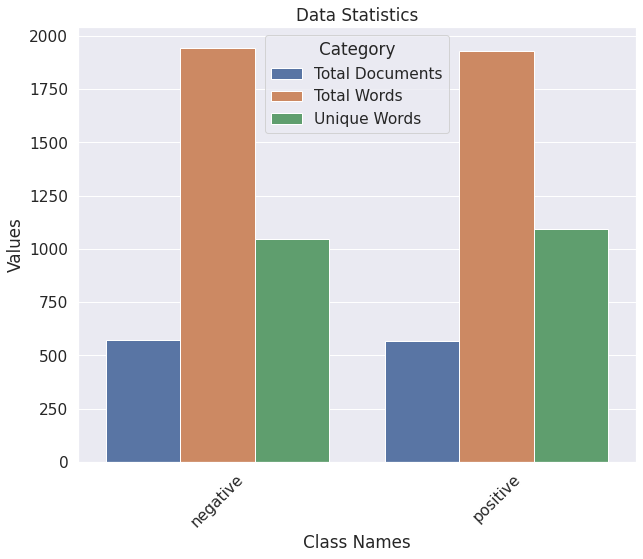

In [28]:
plt.figure(figsize=(10, 8))
ax = plt.subplot()

sns.barplot(data=df,x='Class Names', y='Values' ,hue='Category')
ax.set_xlabel('Class Names') 
ax.set_title('Data Statistics')

ax.xaxis.set_ticklabels(class_names, rotation=45);

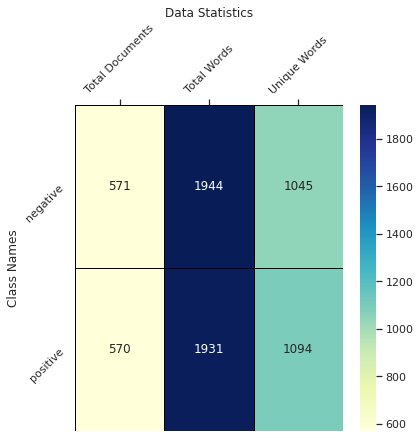

In [29]:
sns.set()
plt.figure(figsize =(6, 6))
ax = plt.subplot()
sns.heatmap(data_matrix.iloc[:,0:3], annot=True,fmt="d", linewidths=0.5,linecolor = 'Black',cmap = "YlGnBu",ax = ax)

ax.set_ylabel('Class Names') 
ax.set_title('Data Statistics')
y_label = ["Total Documents", "Total Words", "Unique Words"] 
ax.xaxis.set_ticklabels(y_label, rotation=45); ax.yaxis.set_ticklabels(class_names, rotation=45);
ax.xaxis.tick_top()

***Label Encoding Function***

In [30]:
def label_encoding(sentiment,bool):
  
    le = LabelEncoder()
    le.fit(sentiment)
    encoded_labels = le.transform(sentiment)
    labels = np.array(encoded_labels)
    class_names =le.classes_
    if bool == True:
        print("\n\t\t\t===== Label Encoding =====","\nClass Names:-->",le.classes_)
        for i in sample_data:
            print(sentiment[i],' ', encoded_labels[i],'\n')

    return labels



***Dataset Splitting Function***

In [ ]:
def dataset_split(feature_space,sentiment):

    X_train,X_test,y_train,y_test = train_test_split(feature_space,sentiment,train_size = 0.8,
                                                  test_size = 0.2,random_state =0)
    print("Feature Size :======>",X_train.shape[1])
    print("\nDataset Distribution:\n")
    print("\tSet Name","\t\tSize")
    print("\t========\t\t======")

    print("\tFull\t\t\t",feature_space.shape[0],
        "\n\tTraining\t\t",X_train.shape[0],
        "\n\tTest\t\t\t",X_test.shape[0])
  
    return X_train,X_test,y_train,y_test

In [ ]:
dataset.cleaned = dataset.cleaned.apply(lambda x:x.replace('\n',' '))

 ***Unigram Tf-idf value calculation ***

In [ ]:
def calc_gram_tfidf(Conversations):
    tfidf = TfidfVectorizer(ngram_range=(1,3),use_idf=True,tokenizer=lambda x: x.split()) 
    X = tfidf.fit_transform(Conversations)
    
    return tfidf,X

# ***Importing ML Classifiers***

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report

***Classifiers Defination***

In [ ]:
def ml_models_defination(): 
    
    lr_model = LogisticRegression()
    dt_model = DecisionTreeClassifier()
    rf_model = RandomForestClassifier()
    mnb_model = MultinomialNB(alpha=0.12)
    knn_model = KNeighborsClassifier(n_neighbors=3)
    svm_model = SVC(kernel = 'linear', C=1.01, degree=1, gamma='auto')
    sgd_model = SGDClassifier(loss = 'log',penalty='l2', max_iter=5)
    model_names = ['Logistic Regression','Decision Tree','Random Forest','Naive Bayes','KNN','SVM','sgd']
  
    ml_models = [lr_model,dt_model,rf_model,mnb_model,knn_model,svm_model,sgd_model]

    return ml_models,model_names 

***Model Evaluation Function***

In [ ]:
def model_performace(model,X_train,X_test,y_train,y_test):
    
    my_dict = {}
    model.fit(X_train,y_train)
 
    pred_y = model.predict(X_test)
    my_dict['Accuracy'] = round(accuracy_score(y_test, pred_y),4)*100
    my_dict['Precision'] = round(precision_score(y_test, pred_y),4)*100 
    my_dict['Recall'] = round(recall_score(y_test, pred_y),4)*100 
    my_dict['F1 Score'] = round(f1_score(y_test, pred_y),4)*100

    return my_dict 

***Model Performane into Dataframe***

In [ ]:
def performance_table(performance_dict):

    acc_list = []
    pr_list = []
    re_list = []
    f1_list = []
    
    for i in performance_dict.keys():
        acc_list.append(performance_dict[i]['Accuracy'])
        pr_list.append(performance_dict[i]['Precision'])
        re_list.append(performance_dict[i]['Recall'])
        f1_list.append(performance_dict[i]['F1 Score'])
        
    model_names = ['Logistic Regression','Decision Tree','Random Forest','Multi. Naive Bayes','KNN','SVM','SGD']
    performance_df = pd.DataFrame({'Accuracy':acc_list,'Precision':pr_list,
                                   'Recall':re_list,'F1 Score':f1_list,'Model Name':model_names })
    return performance_df

***Save the performance of the model for each gram feature***

In [ ]:
gram_names = ['Unigram','Bigram','Trigram']
ngrams = [(1,1),(1,2),(1,3)]


for i,gram in enumerate(ngrams):
    tfidf,feature = calc_gram_tfidf(dataset.cleaned)
    labels = label_encoding(dataset.Sentiment,False)
    X_train,X_test,y_train,y_test = dataset_split(feature,labels) 
    ml_models,model_names = ml_models_defination()
    accuracy = {f'{model_names[j]}':model_performace(model,X_train,X_test,y_train,y_test) for j,model in enumerate(ml_models)}

    with open(f'ml_performance_{gram_names[i]}.json', 'w') as f:
          json.dump(accuracy,f)

***Table for Accuracy along with Precision, Recall and F1_Score***

In [ ]:
table = performance_table(accuracy)
df3 =pd.DataFrame(table)
table

In [ ]:
print(f"Highest Accuracy achieved by {table.Accuracy.idxmax(axis = 0)} at = {max(table.Accuracy)}")
print(f"Highest F1-Score achieved by {table['F1 Score'].idxmax(axis = 0)} at = {max(table['F1 Score'] )}")
print(f"Highest Precision Score achieved by {table['Precision'].idxmax(axis = 0)} at = {max(table['Precision'] )}")
print(f"Highest Recall Score achieved by {table['Recall'].idxmax(axis = 0)} at = {max(table['Recall'] )}")

In [ ]:
df3.iplot()

***Select best classifier model***

In [ ]:
svm_model = SVC(kernel = 'linear', C=1.01, degree=1, gamma='auto')
svm_model.fit(X_train, y_train)
svm_model.score(X_test,y_test)

***Confusion matrix***

In [ ]:
y_pred = svm_model.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

# ***Test Our Model With Random Data***

In [ ]:
import pickle
file = open('cs_svm.pkl', 'wb')
pickle.dump(svm_model, file)

In [ ]:
model = open('cs_svm.pkl','rb')
svm_model = pickle.load(model)
Conversation = 'মামা কি অবস্থা আজকে তো এল ক্লাসিকো খেলা আছে কে জিতবে রিয়াল নাকি বার্সা তো খেলাটা কোন চ্যানেলে দেখাবে.... খেলা রাত 11 টায় সনি টিভিতে দেখাবে তো আমার বাসায় আসিস একসাথে দেখব আচ্ছা মামা ঠিক আছে ঝালমুড়ি রেডি রাখিস'
processed_conversation = process_conversations(Conversation)
if (len(processed_conversation))>0:
    cv,feature_vector = calc_gram_tfidf(dataset.cleaned) 
    feature = cv.transform([processed_conversation]).toarray()
    sentiment = svm_model.predict(feature)
    if (sentiment ==0):
        print(f"It is a Negative conversation")
    else:
        print(f"It is a Positive conversation")
else:
    print("This conversation doesn't contains any bengali Words, thus cannot predict the Sentiment.")